In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold

import os
from timeit import default_timer as timer

# Set Parameters

In [2]:
#input_dim = 37   # version1
#input_dim = 52   # version2
#input_dim = 103   # version3
input_dim = 104   # version4
output_dim = 1

k_fold_models=10

n_hidden   = 2048
learning_rate = 0.000005
learning_rate2 = 0.000002
learning_rate3 = 0.000001

keep_rate = 0.9

n_epoch = 1001
batch_size   = 20

save_folder_name = 'titanic_v4'
save_file_name = 'titanic_v4'

save_path = "/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/"+save_folder_name
log_path = "/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/log/"+save_folder_name

print_step =10

tf.set_random_seed(20190202)

# Import Data

In [3]:
path = '/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/data_preprocess'

train_file = '/train_preprocess4.csv'
test_file = '/test_preprocess4.csv'
label_file = '/label_preprocess4.csv'

train_data = pd.read_csv(path+train_file)
test_data = pd.read_csv(path+test_file)
label_data = pd.read_csv(path+label_file)

In [4]:
X_train = np.array(train_data)[:, 1:]
Y_train = np.array(label_data)
X_test = np.array(test_data)[:, 1:]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(891, 104)
(891, 1)
(418, 104)


# Model

In [6]:
def weight_variable(name, shape):
    #initial = tf.truncated_normal(shape, stddev=0.01)
    initial = tf.keras.initializers.he_normal(seed=20190207)
    #return tf.Variable(initial)
    return tf.get_variable(name, shape=shape, initializer=initial)
    
def bias_variable(shape):
    initial = tf.zeros(shape, dtype=tf.float32)
    return initial
       
        
def Network(x, dropout_rate=1.0):
    
    with tf.variable_scope('network', reuse=tf.AUTO_REUSE ):
        
        # 1st layer
        W1 = weight_variable('W1', [input_dim, n_hidden])
        B1 = bias_variable([n_hidden])
        layer1 = tf.add( tf.matmul(x, W1), B1 )
        #layer1 = tf.layers.batch_normalization(layer1)
        layer1 = tf.nn.relu(layer1)
        layer1 = tf.nn.dropout( layer1, keep_prob=dropout_rate )
        
        # 2nd layer
        W2 = weight_variable('W2', [n_hidden, n_hidden])
        B2 = bias_variable([n_hidden])
        layer2 = tf.add( tf.matmul(layer1, W2), B2 )
        #layer2 = tf.layers.batch_normalization(layer2)
        layer2 = tf.nn.relu(layer2)
        layer2 = tf.nn.dropout( layer2, keep_prob=dropout_rate )
        
        # 3rd layer
        W3 = weight_variable('W3', [n_hidden, n_hidden])
        B3 = bias_variable([n_hidden])
        layer3 = tf.add( tf.matmul(layer2, W3), B3 )
        #layer3 = tf.layers.batch_normalization(layer3)
        layer3 = tf.nn.relu(layer3)
        layer3 = tf.nn.dropout( layer3, keep_prob=dropout_rate )
        
        # 4th layer
        W4 = weight_variable('W4', [n_hidden, n_hidden])
        B4 = bias_variable([n_hidden])
        layer4 = tf.add( tf.matmul(layer3, W4), B4 )
        #layer3 = tf.layers.batch_normalization(layer3)
        layer3 = tf.nn.relu(layer3)
        layer4 = tf.nn.dropout( layer4, keep_prob=dropout_rate )
        
    return layer4


def final_node(x):
    with tf.variable_scope('Final', reuse=tf.AUTO_REUSE ):     # false test
        WF = weight_variable('WF', [n_hidden, output_dim])
        BF = bias_variable([output_dim])
        logit = tf.add( tf.matmul(x, WF), BF)
        #logit = tf.layers.batch_normalization(logit)
        hypothesis = tf.nn.sigmoid(logit)
        
    return logit, hypothesis

In [7]:
class ANN:
    
    def __init__(self, sess, name):
        
        self.sess = sess
        self.name = name
        self._build_model()
        
        
    def _build_model(self):
        
        self.X = tf.placeholder(tf.float32, [None, input_dim], name='X')
        self.Y = tf.placeholder(tf.float32, [None, output_dim], name='Y')
        
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        self.l_rate = tf.placeholder(tf.float32, name='learning_rate')

        result = Network(self.X, self.keep_prob)
        logits, hypothesis = final_node(result)
        
        self.predict = tf.to_float(tf.greater(hypothesis, 0.5), name='predict')
        self.accuracy = tf.reduce_mean( tf.cast( tf.equal( self.predict, self.Y ), tf.float32 ), name='accuracy' )
        
        self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.Y, logits=logits), name='loss')
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.loss)

        # Saver
        self.saver = tf.train.Saver(max_to_keep=3)
        

    #Train
    def train(self, X_train, Y_train, l_rate, keep_prob):
        return self.sess.run([self.optimizer, self.loss], feed_dict={self.X: X_train, self.Y: Y_train,
                                                                                                  self.l_rate: l_rate,
                                                                                                  self.keep_prob: keep_prob})

    def result(self, X_result, Y_result, keep_prob=1.0):
        return self.sess.run([self.predict, self.accuracy], feed_dict={self.X: X_result, self.Y: Y_result,
                                                                                                      self.keep_prob: keep_prob})
    
    def get_loss(self, X_loss, Y_loss, keep_prob=1.0, is_training=False):
        return self.sess.run(self.loss, feed_dict={self.X: X_loss, self.Y: Y_loss,
                                                                        self.keep_prob: keep_prob})
    
    def train_saver(self, save_path):
        self.saver.save(self.sess, save_path)
        return 

# Saver

In [8]:
# Saver
save_dir = []
log_dir = []

for m_idx in range(k_fold_models):
    save_dir.append(save_path+"/"+str(m_idx))
    log_dir.append(log_path+"/"+str(m_idx))
    
    if not os.path.exists(save_dir[m_idx]):
        os.makedirs(save_dir[m_idx])
    if not os.path.exists(log_dir[m_idx]):
        os.makedirs(log_dir[m_idx])

# Training

In [9]:
class EarlyStopping():
    
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose
        
    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        
        else:
            self._step = 0
            self._loss = loss
        
        return False

In [10]:
kf = KFold(n_splits=k_fold_models, shuffle=True)
step = 0

models=[]
m_idx=0

loss_train_matrix = np.full((k_fold_models, n_epoch), np.inf)
loss_valid_matrix = np.full((k_fold_models, n_epoch), np.inf)
acc_valid_matrix = np.full((k_fold_models, n_epoch), -np.inf)


#for m in range(k_fold_models):
for train_idx, valid_idx in kf.split(X_train):
    early_stopping = EarlyStopping(patience=30, verbose=1)
    
    CV_X_train = X_train[train_idx]
    CV_X_valid = X_train[valid_idx]
    CV_Y_train = Y_train[train_idx]
    CV_Y_valid = Y_train[valid_idx]
    
    tf.reset_default_graph()
    
    turn = 0
    with tf.Session() as sess:
        
        models.append(ANN(sess, "model"+str(m_idx) ))
        tf.initialize_all_variables().run()
    
        writer = tf.summary.FileWriter(log_dir[m_idx])
        writer.add_graph(sess.graph)
         
        batch_order=list(range(CV_X_train.shape[0]))
    
        for epoch in range(n_epoch):
        
            start=timer()
            l_train_ave = 0
            b=0
            
            np.random.seed(epoch*4)
            np.random.shuffle(batch_order)
                
            while b < CV_X_train.shape[0]:
                if b+batch_size >= CV_X_train.shape[0]:
                    b_ = CV_X_train.shape[0]
                else:
                    b_ = b + batch_size

                X_batch = CV_X_train[batch_order[b:b_]]
                Y_batch = CV_Y_train[batch_order[b:b_]]

                _, l_train = models[m_idx].train(X_batch, Y_batch, learning_rate, keep_rate)
                
                l_train_ave += l_train/(CV_X_train.shape[0]//batch_size +1)
                b += batch_size
                
            loss_train_matrix[m_idx, epoch] = l_train_ave
            loss_valid_matrix[m_idx, epoch] = models[m_idx].get_loss(CV_X_valid, CV_Y_valid)
            
            _, _accuracy = models[m_idx].result(CV_X_valid, CV_Y_valid)
            acc_valid_matrix[m_idx, epoch] = _accuracy
            
            if _accuracy > 0.85:
                turn += 1
                if turn == 1:
                    print('reach 0.85')
                    
            if _accuracy >= 0.8 and _accuracy < 0.85:
                learning_rate = learning_rate2
            else:
                learning_rate = learning_rate3
            
            if epoch % print_step == 0:
                end = timer()
                    
                if epoch == 0: 
                    speed = round(end-start,2)
                else:
                    speed = round(end-start, 2)
                    
                print("[%d th model] %d th epoch, Loss (train/valid) :  %.3f / %.3f (%.2f sec)" %(m_idx+1, epoch, loss_train_matrix[m_idx, epoch], loss_valid_matrix[m_idx, epoch], speed) )
                
                #_, _accuracy = models[m_idx].result(CV_X_valid, CV_Y_valid)
                print("[%d th model] %d th epoch, accuracy :  %.3f" %(m_idx+1, epoch, _accuracy) )

                               
            if loss_valid_matrix[m_idx, epoch] <= np.min(loss_valid_matrix[m_idx]):
            #if acc_valid_matrix[m_idx, epoch] >= np.max(acc_valid_matrix[m_idx]):
                savename_valid = save_dir[m_idx]+"/"+save_file_name+"-validmin-"+str(epoch)+".ckpt"
                models[m_idx].train_saver(savename_valid)
                print("[%d th model] %sth epoch is saved as the minimum loss of validation" % (m_idx+1, epoch) )
            

            if early_stopping.validate(loss_valid_matrix[m_idx, epoch]):
                break
        
    m_idx+=1
    writer.close()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
[1 th model] 0 th epoch, Loss (train/valid) :  0.567 / 0.448 (2.08 sec)
[1 th model] 0 th epoch, accuracy :  0.778
[1 th model] 0th epoch is saved as the minimum loss of validation
[1 th model] 1th epoch is saved as the minimum loss of validation
[1 th model] 2th epoch is saved as the minimum loss of validation
[1 th model] 3th epoch is saved as the minimum loss of validation
reach 0.85
[1 th model] 4th epoch is saved as the minimum loss of validation
[1 th model] 5th epoch is saved as the minimum loss of validation
[1 th model] 6th epoch is saved as the minimum loss of validation
[1 th model] 7th epoch is saved as the minimum loss of validation
[1 th model] 8th epoch is saved as the minimum loss of validation
[1 th model] 9th epoch is saved as the minimum loss of validation
[1 th model] 10 th epoch, Loss (train/valid) :  0.455 / 0.370 (2.16 sec)
[1 th model] 10 th epoch, accuracy :  0.856
[1 th model] 11th epoch

[2 th model] 24th epoch is saved as the minimum loss of validation
[2 th model] 30 th epoch, Loss (train/valid) :  0.388 / 0.464 (1.96 sec)
[2 th model] 30 th epoch, accuracy :  0.798
[2 th model] 40 th epoch, Loss (train/valid) :  0.398 / 0.465 (1.97 sec)
[2 th model] 40 th epoch, accuracy :  0.787
[2 th model] 46th epoch is saved as the minimum loss of validation
[2 th model] 49th epoch is saved as the minimum loss of validation
[2 th model] 50 th epoch, Loss (train/valid) :  0.371 / 0.457 (2.32 sec)
[2 th model] 50 th epoch, accuracy :  0.809
[2 th model] 60 th epoch, Loss (train/valid) :  0.356 / 0.458 (1.97 sec)
[2 th model] 60 th epoch, accuracy :  0.809
[2 th model] 70 th epoch, Loss (train/valid) :  0.331 / 0.459 (1.96 sec)
[2 th model] 70 th epoch, accuracy :  0.809
[2 th model] 80 th epoch, Loss (train/valid) :  0.332 / 0.464 (1.96 sec)
[2 th model] 80 th epoch, accuracy :  0.820
early stopping
[3 th model] 0 th epoch, Loss (train/valid) :  0.623 / 0.513 (2.30 sec)
[3 th mode

[4 th model] 21th epoch is saved as the minimum loss of validation
[4 th model] 22th epoch is saved as the minimum loss of validation
[4 th model] 23th epoch is saved as the minimum loss of validation
[4 th model] 27th epoch is saved as the minimum loss of validation
[4 th model] 28th epoch is saved as the minimum loss of validation
[4 th model] 29th epoch is saved as the minimum loss of validation
[4 th model] 30 th epoch, Loss (train/valid) :  0.403 / 0.391 (2.13 sec)
[4 th model] 30 th epoch, accuracy :  0.876
[4 th model] 31th epoch is saved as the minimum loss of validation
[4 th model] 34th epoch is saved as the minimum loss of validation
[4 th model] 40 th epoch, Loss (train/valid) :  0.419 / 0.384 (1.96 sec)
[4 th model] 40 th epoch, accuracy :  0.876
[4 th model] 43th epoch is saved as the minimum loss of validation
[4 th model] 45th epoch is saved as the minimum loss of validation
[4 th model] 47th epoch is saved as the minimum loss of validation
[4 th model] 48th epoch is sa

[6 th model] 33th epoch is saved as the minimum loss of validation
[6 th model] 34th epoch is saved as the minimum loss of validation
[6 th model] 40 th epoch, Loss (train/valid) :  0.381 / 0.487 (1.97 sec)
[6 th model] 40 th epoch, accuracy :  0.787
[6 th model] 50 th epoch, Loss (train/valid) :  0.393 / 0.491 (2.01 sec)
[6 th model] 50 th epoch, accuracy :  0.787
[6 th model] 56th epoch is saved as the minimum loss of validation
[6 th model] 60 th epoch, Loss (train/valid) :  0.363 / 0.488 (1.97 sec)
[6 th model] 60 th epoch, accuracy :  0.798
[6 th model] 70 th epoch, Loss (train/valid) :  0.354 / 0.489 (1.98 sec)
[6 th model] 70 th epoch, accuracy :  0.798
[6 th model] 80 th epoch, Loss (train/valid) :  0.353 / 0.489 (1.98 sec)
[6 th model] 80 th epoch, accuracy :  0.798
early stopping
[7 th model] 0 th epoch, Loss (train/valid) :  0.666 / 0.554 (2.29 sec)
[7 th model] 0 th epoch, accuracy :  0.674
[7 th model] 0th epoch is saved as the minimum loss of validation
[7 th model] 1th e

[10 th model] 10 th epoch, Loss (train/valid) :  0.450 / 0.484 (2.32 sec)
[10 th model] 10 th epoch, accuracy :  0.753
[10 th model] 11th epoch is saved as the minimum loss of validation
[10 th model] 12th epoch is saved as the minimum loss of validation
[10 th model] 13th epoch is saved as the minimum loss of validation
[10 th model] 15th epoch is saved as the minimum loss of validation
[10 th model] 17th epoch is saved as the minimum loss of validation
[10 th model] 19th epoch is saved as the minimum loss of validation
[10 th model] 20 th epoch, Loss (train/valid) :  0.421 / 0.445 (2.32 sec)
[10 th model] 20 th epoch, accuracy :  0.820
[10 th model] 20th epoch is saved as the minimum loss of validation
[10 th model] 21th epoch is saved as the minimum loss of validation
[10 th model] 24th epoch is saved as the minimum loss of validation
[10 th model] 27th epoch is saved as the minimum loss of validation
[10 th model] 30 th epoch, Loss (train/valid) :  0.402 / 0.438 (1.95 sec)
[10 th m

# Loss

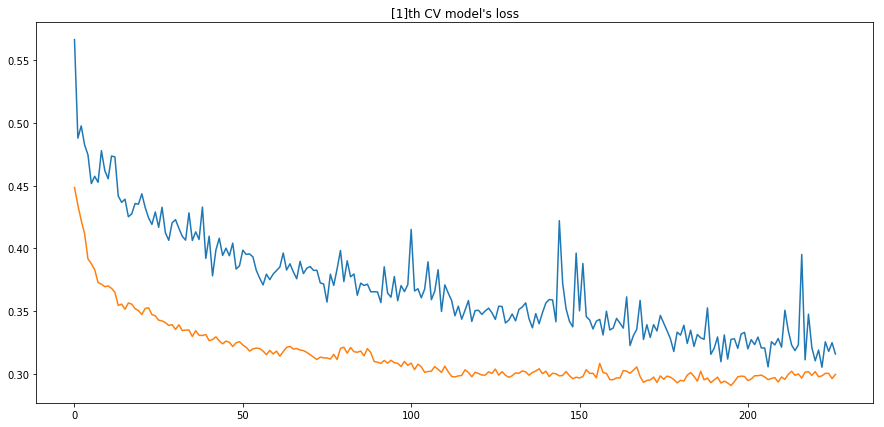

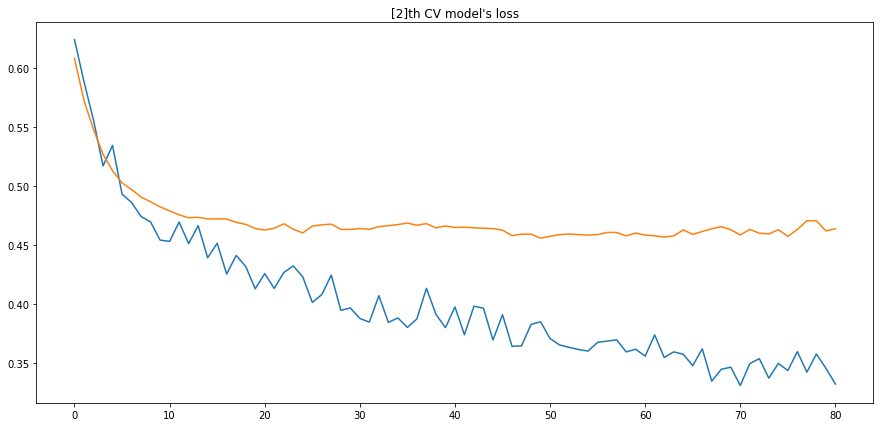

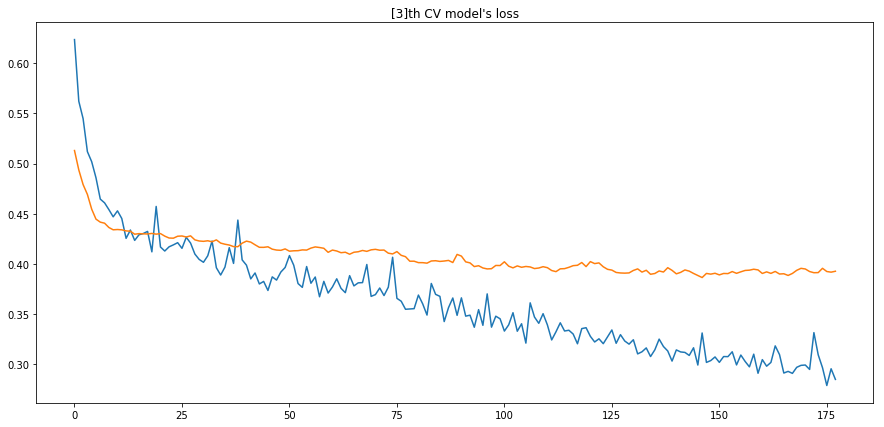

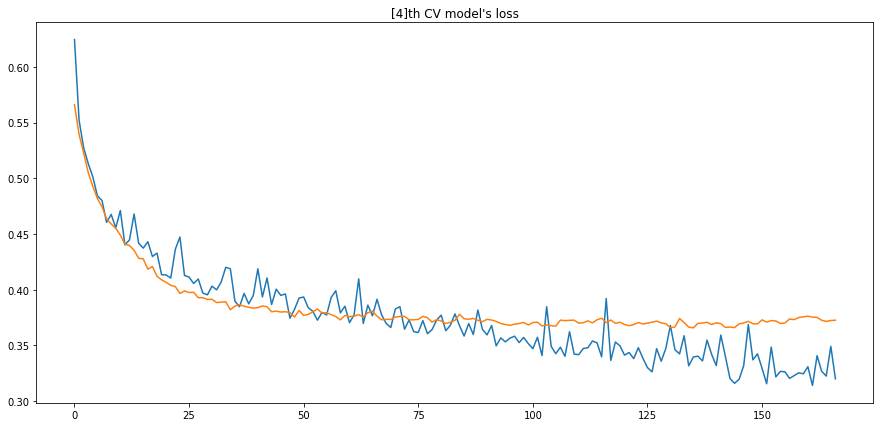

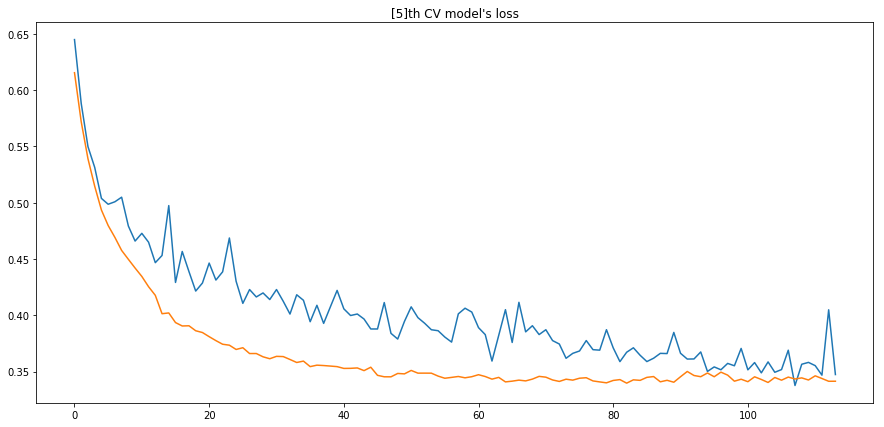

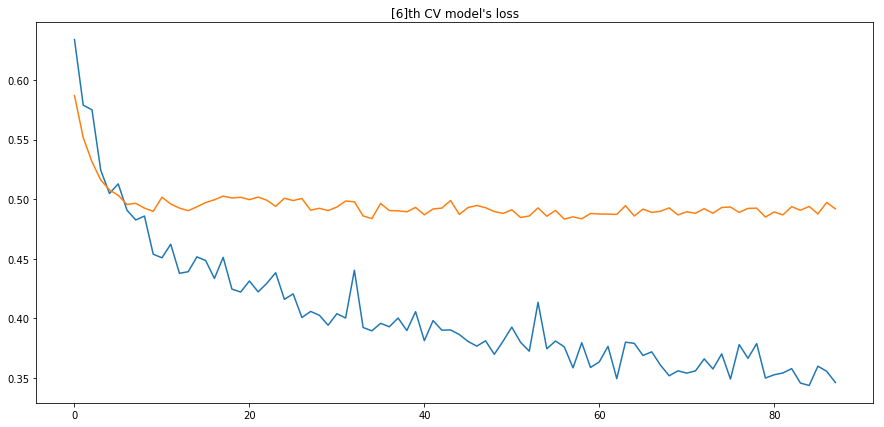

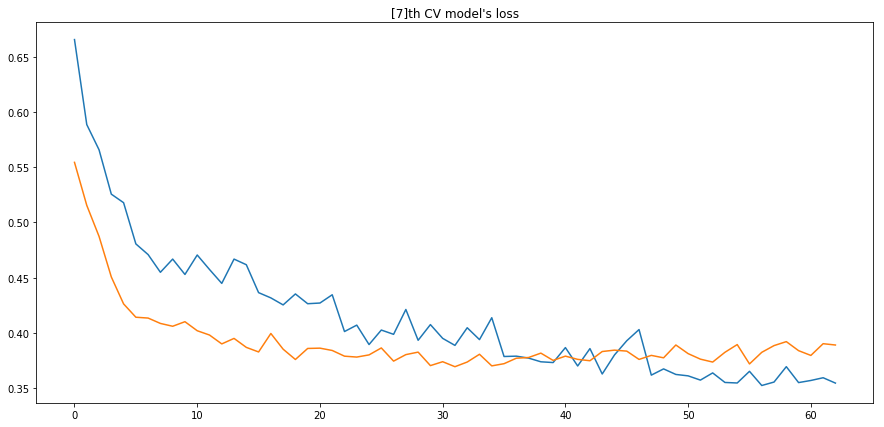

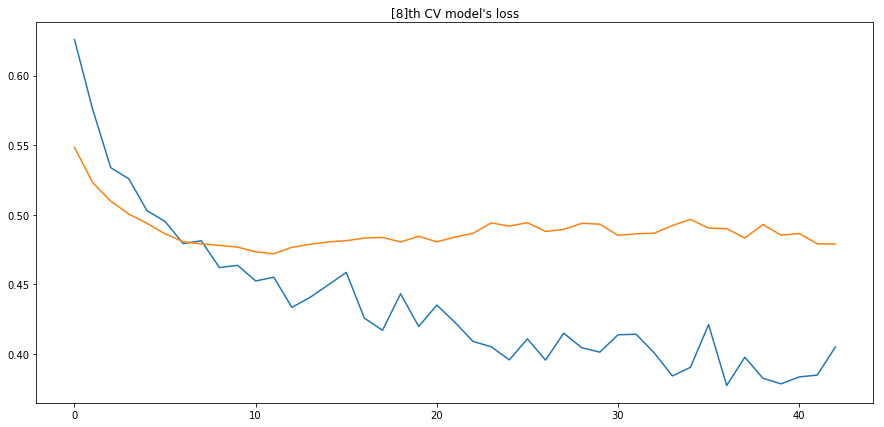

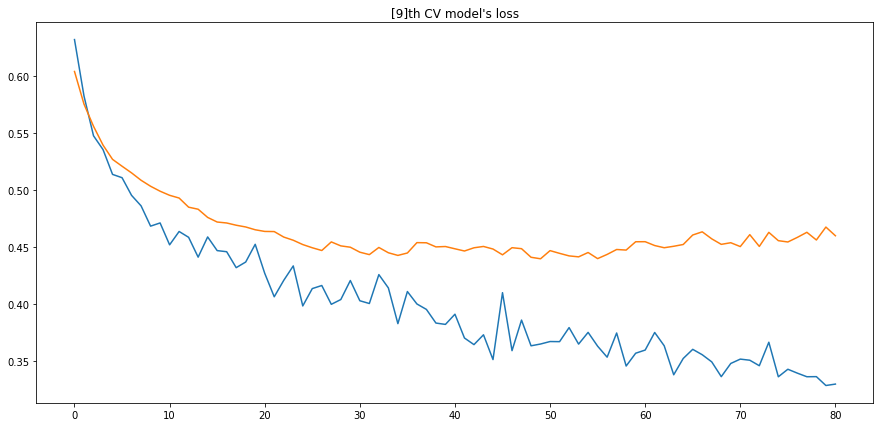

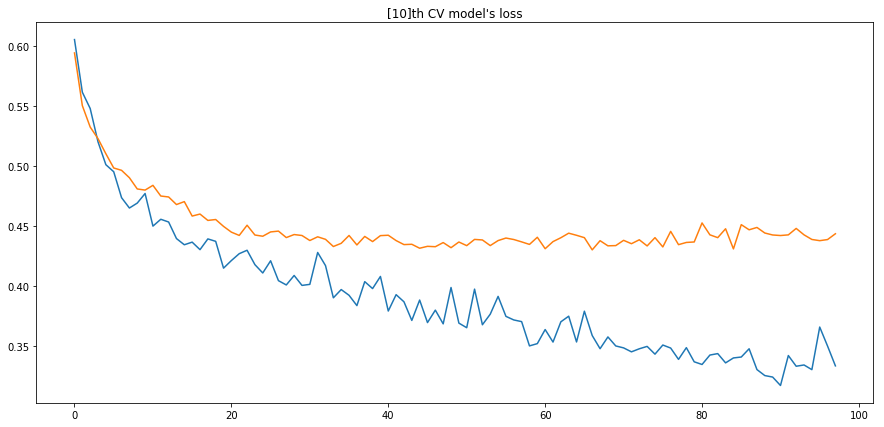

In [11]:
# 5. loss tendency

for m_idx in range(k_fold_models):
    plt.figure(figsize=(15,7))
    plt.plot(loss_train_matrix[m_idx,:])
    plt.plot(loss_valid_matrix[m_idx,:])
    plt.title("[%d]th CV model's loss" % (m_idx+1))

# Results

In [12]:
results=[]
losses=[]
accuracys=[]

#for m_idx, m in enumerate(models):
for m_idx in range(k_fold_models):
    load_meta = save_dir[m_idx]+"/"+save_file_name+"-validmin-"+str(np.argmin(loss_valid_matrix[m_idx]))+".ckpt.meta"
    #load_meta = save_dir[m_idx]+"/"+save_file_name+"-validmin-"+str(np.max(np.where(acc_valid_matrix[m_idx] == np.max(acc_valid_matrix[m_idx]))))+".ckpt.meta"
    
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(load_meta)
        saver.restore(sess, tf.train.latest_checkpoint(save_dir[m_idx]))
        print(save_dir[m_idx])
    
        graph = tf.get_default_graph()
        
        X = graph.get_tensor_by_name("X:0")
        Y = graph.get_tensor_by_name("Y:0")

        keep_prob = graph.get_tensor_by_name("keep_prob:0")
        
        loss = graph.get_tensor_by_name("loss:0")
        
        predict = graph.get_tensor_by_name("predict:0")
        accuracy = graph.get_tensor_by_name("accuracy:0")
        
        loss = sess.run(loss, feed_dict={X: X_train, Y: Y_train, keep_prob: 1.0})
        train_result = sess.run(predict, feed_dict={X:X_train, keep_prob: 1.0})
        train_accuracy = sess.run(accuracy, feed_dict={X: X_train, Y:Y_train, keep_prob: 1.0})
        
        results.append(train_result)
        losses.append(loss)
        accuracys.append(train_accuracy)

results = np.array(results)
losses = np.array(losses)
accuracys = np.array(accuracys)

INFO:tensorflow:Restoring parameters from /Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/0/titanic_v4-validmin-195.ckpt
/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/0
INFO:tensorflow:Restoring parameters from /Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/1/titanic_v4-validmin-49.ckpt
/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/1
INFO:tensorflow:Restoring parameters from /Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/2/titanic_v4-validmin-146.ckpt
/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/2
INFO:tensorflow:Restoring parameters from /Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/3/titanic_v4-validmin-135.ckpt
/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/3
INFO:tensorflow:Restoring parameters from /Us

In [13]:
path = '/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/data/'
verify_file='train.csv'

verify = pd.read_csv(path+verify_file)

In [14]:
results.shape

(10, 891, 1)

In [15]:
final = np.round(np.mean(results, axis=0))
#final= np.round(results[8,:,:])
#final= np.round(results[0,:,:]/3 + results[9,:,:]/3)

In [16]:
incorrect = []
score=0

for i in range(final.shape[0]):
    if final[i,0] != Y_train[i,0]:
        incorrect.append(i)
    else:
        score += 1/final.shape[0] * 100

In [17]:
verify.loc[incorrect]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
41,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
49,50,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.0,1,0,349237,17.8000,NaN,S
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S


In [18]:
score

87.09315375981954

# Submission

In [19]:
results=[]

#for m_idx, m in enumerate(models):
for m_idx in range(k_fold_models):
    load_meta = save_dir[m_idx]+"/"+save_file_name+"-validmin-"+str(np.argmin(loss_valid_matrix[m_idx]))+".ckpt.meta"
    #load_meta = save_dir[m_idx]+"/"+save_file_name+"-validmin-"+str(np.max(np.where(acc_valid_matrix[m_idx] == np.max(acc_valid_matrix[m_idx]))))+".ckpt.meta"
    
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(load_meta)
        saver.restore(sess, tf.train.latest_checkpoint(save_dir[m_idx]))
        print(save_dir[m_idx])
    
        graph = tf.get_default_graph()
        
        X = graph.get_tensor_by_name("X:0")
        Y = graph.get_tensor_by_name("Y:0")
        keep_prob = graph.get_tensor_by_name("keep_prob:0")
        
        predict = graph.get_tensor_by_name("predict:0")
        
        train_result = sess.run(predict, feed_dict={X:X_test, keep_prob: 1.0})
        
        results.append(train_result)

results = np.array(results)

INFO:tensorflow:Restoring parameters from /Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/0/titanic_v4-validmin-195.ckpt
/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/0
INFO:tensorflow:Restoring parameters from /Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/1/titanic_v4-validmin-49.ckpt
/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/1
INFO:tensorflow:Restoring parameters from /Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/2/titanic_v4-validmin-146.ckpt
/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/2
INFO:tensorflow:Restoring parameters from /Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/3/titanic_v4-validmin-135.ckpt
/Users/rackhun/Desktop/Python/deep_learning/GDG/RNN_study/titanic/save/titanic_v4/3
INFO:tensorflow:Restoring parameters from /Us

In [20]:
final = np.round(np.mean(results, axis=0))
final.astype('int')
final_write = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': final[:,0]})
final_write['Survived']=final_write['Survived'].astype(int)

In [21]:
#final_write.to_csv("./submission/submission.csv", index=False)
#final_write.to_csv("./submission/submission2.csv", index=False)
#final_write.to_csv("./submission/submission3-3.csv", index=False)
final_write.to_csv("./submission/submission4.csv", index=False)